In this blog post, I'm going to try to show how the numerical tools of 2018 allow to efficiently do ray-tracing.  

# Introduction to ray tracing 

Ray tracing is a tool used in many physics discipline since high frequency waves can accurately be approximated by rays. Typical applications include 3D rendering (think [povray](http://www.povray.org)), lens design or acoustic wave simulation (which is what I do professionally).
To trace rays, you usually start with a source and follow reflexions and refractions until some the end of the tracing (exiting the scene, arriving at the camera).

In this context, the goal for this post is to find the ray that connects the source to the camera through a set of reflexions. Let's define the reference configuration for this post. We'll model points with numpy arrays of $(x, y)$ coordinates. 

We define a source and a camera, as well as an interface that separates the two bounding media that have different speeds.

In [1]:
import numpy as np

In [2]:
source = np.array([0., 1.]).reshape(-1, 1)
camera = np.array([1., -1.]).reshape(-1, 1)
interface_y = 0.

Let's plot this.

In [3]:
import matplotlib.pyplot as plt
%matplotlib notebook

<IPython.core.display.Javascript object>


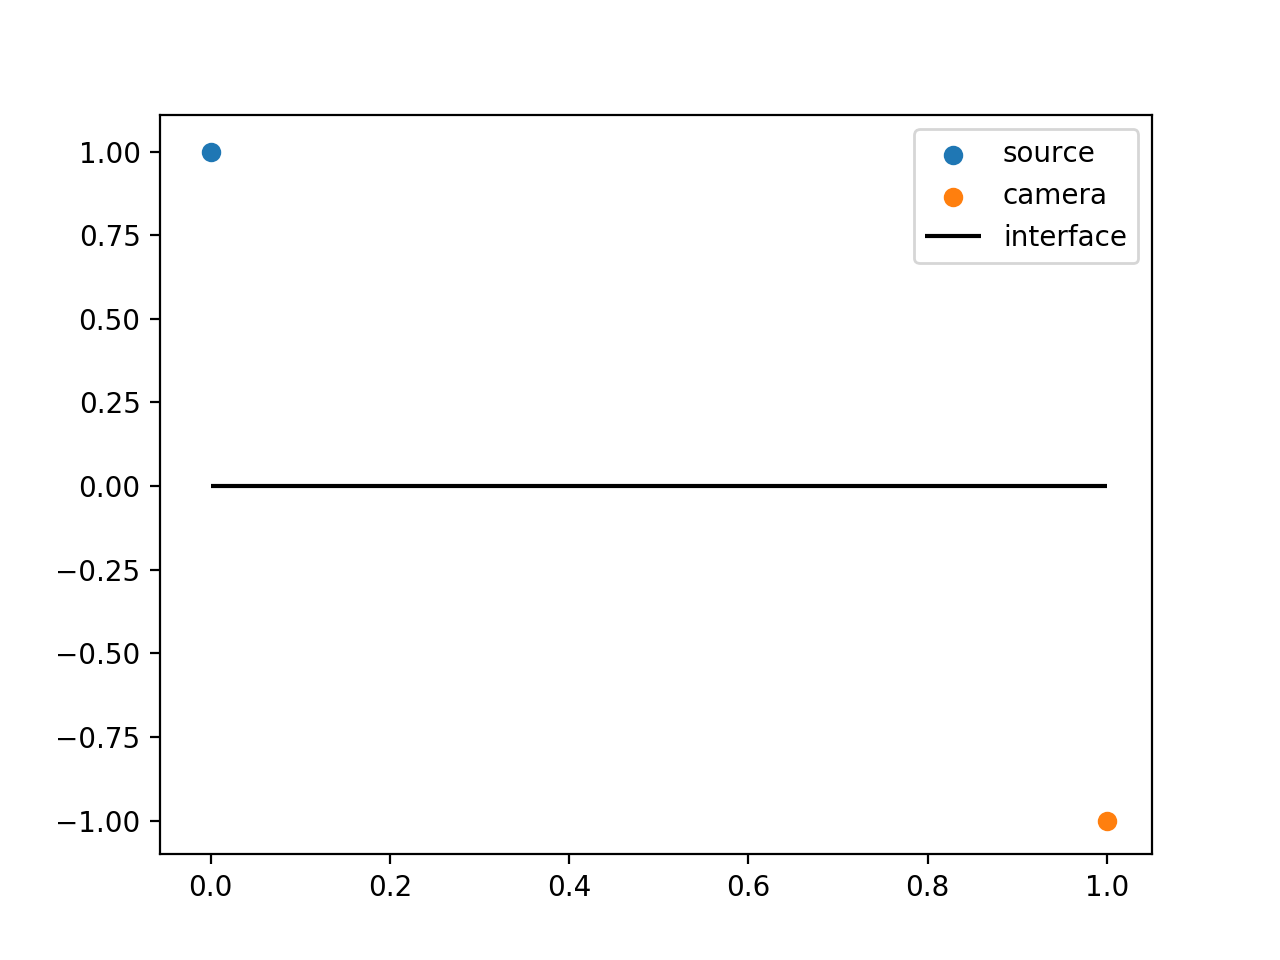

In [4]:
fig, ax = plt.subplots()
ax.scatter(*source, label='source')
ax.scatter(*camera, label='camera')
ax.hlines(interface_y, 0, 1, label='interface')
ax.legend()

So, the question we're asking is: what should the ray from source to camera and refracting across the interface be?

There are several ways to answer this question. We'll choose one: [Fermat's principle of least time](https://en.wikipedia.org/wiki/Fermat%27s_principle) states that the ray chooses the trajectory taking the least time to travel. Computing a time of flight is easy since rays travel in straight lines and thus $t = d / v$ where $v$ denotes the speed in the medium. Since we're using the example of light, we will use the formule $t = d * n$ where $n$ is the [refractive index of the medium](https://en.wikipedia.org/wiki/Refractive_index).

Let's see how this works in the case of our example, where we denote by $x$ the location of the refraction point on the horizontal interface.

We model the top medium to be air and the bottom medium to be water.

In [5]:
n1, n2 = 1., 1.333

In [6]:
# euclidian distance written as numpy function
dist = lambda vector: np.sqrt(np.sum(np.square(vector.ravel()))) 

In [7]:
def tof(x):
    """Returns time of flight for ray passing through point (x, 0) on the interface."""
    interface_point = np.array([x, 0.]).reshape(-1, 1)
    return dist(source - interface_point) * n1 + dist(interface_point - camera) * n2

Let's do a sort of line search to determine the minimal time of flight for points of abscissa between 0 and 1.

In [8]:
x_candidates = np.linspace(0, 1, num=200)
tofs = tof(x_candidates)

<IPython.core.display.Javascript object>


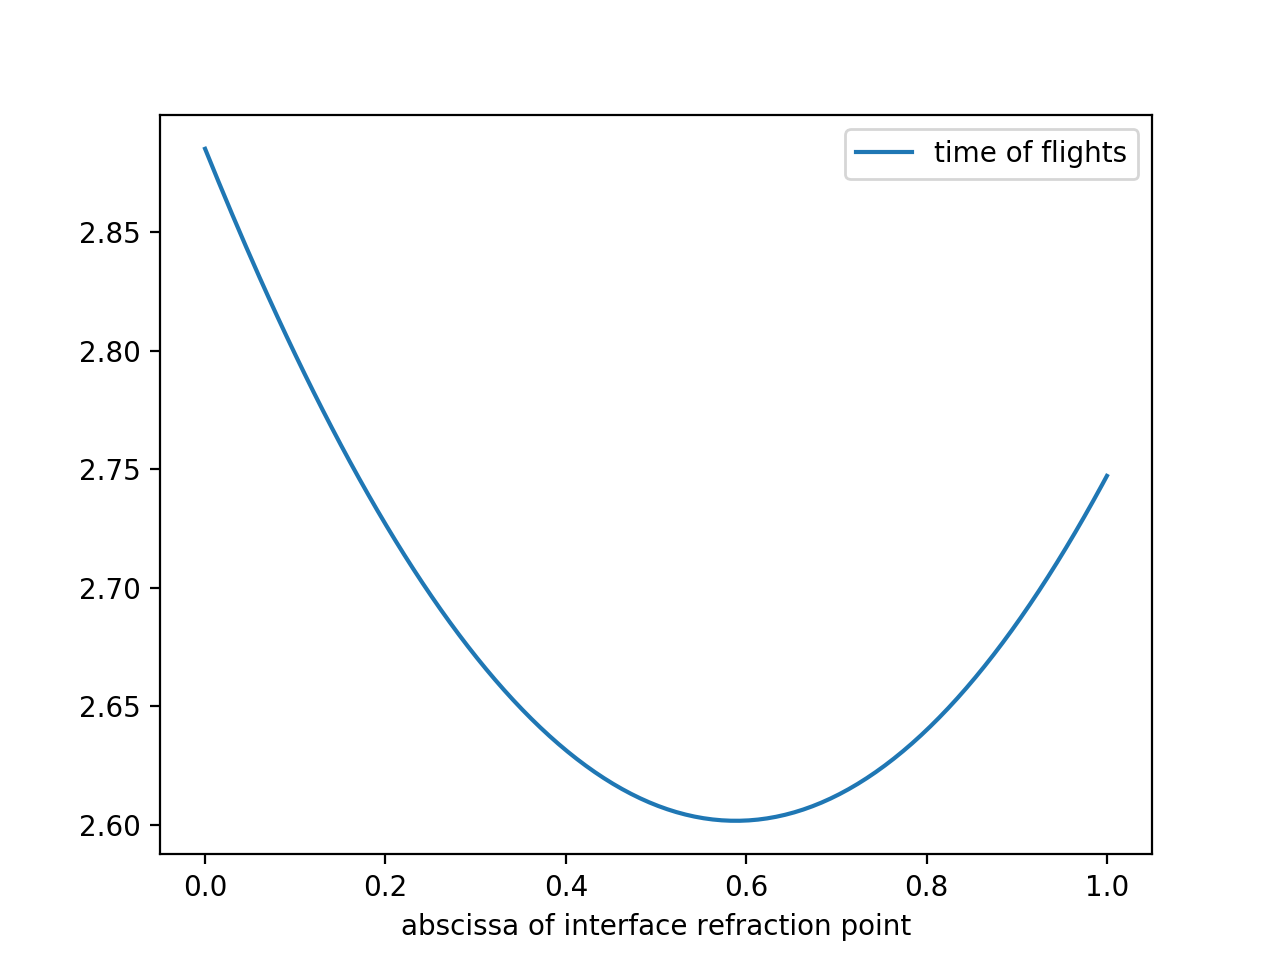

Text(0.5,0,'abscissa of interface refraction point')

In [9]:
fig, ax = plt.subplots()
ax.plot(x_candidates, tofs, label='time of flights')
ax.legend()
ax.set_xlabel('abscissa of interface refraction point')

As expected, we find a minimum time of flight, which is the "true" one. Let's plot all possible rays from this search and color them by their times of flight.

In [10]:
import matplotlib as mpl
norm = mpl.colors.Normalize(vmin=tofs.min(),vmax=tofs.max())
cmap = plt.cm.get_cmap('plasma_r')

<IPython.core.display.Javascript object>


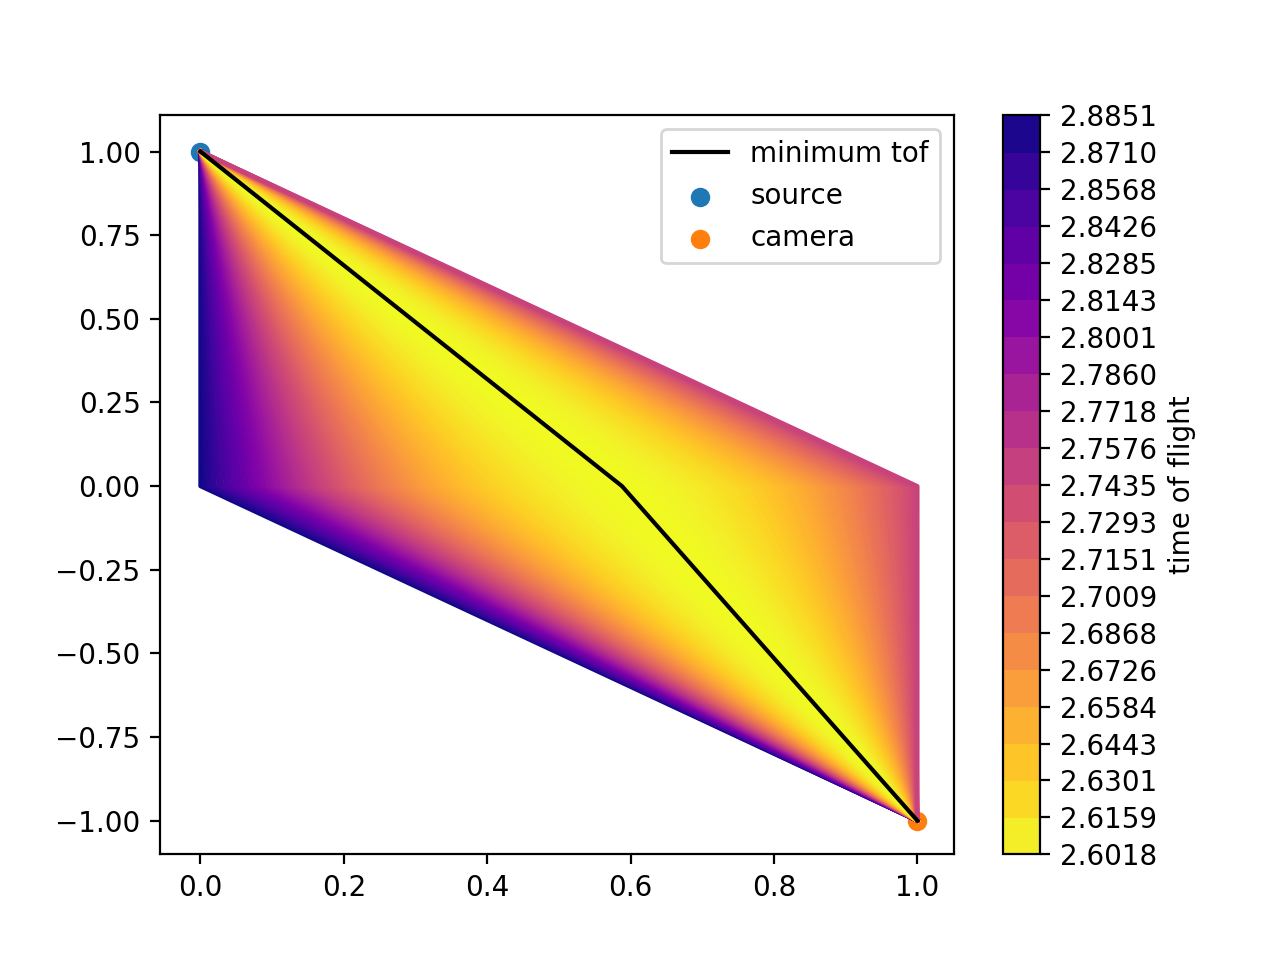

In [11]:
fig, ax = plt.subplots()
ax.scatter(*source, label='source')
ax.scatter(*camera, label='camera')
for x in x_candidates:
    interface_point = np.array([x, 0.]).reshape(-1, 1)
    points = np.concatenate((source, interface_point, camera), axis=1).T
    ax.plot(points[:, 0], points[:, 1], color=cmap(norm(tof(x))))

# plotting the minimum time of flight
x = x_candidates[np.argmin(tofs)]
interface_point = np.array([x, 0.]).reshape(-1, 1)
points = np.concatenate((source, interface_point, camera), axis=1).T
ax.plot(points[:, 0], points[:, 1], color='k', label='minimum tof')
ax.legend()


# plotting the colorbar, see https://stackoverflow.com/questions/43805821/matplotlib-add-colorbar-to-non-mappable-object
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, 
             ticks=np.linspace(tofs.min(),tofs.max(),21),
             boundaries=np.linspace(tofs.min(),tofs.max(),21),
            label='time of flight')


# Iterative algorithms 

Now, the interesting point here is: in the general case, you don't want to compute all possible rays and choose the one with minimum time of flight. Instead, you just change the refraction point location until it is minimal. This is a typical optimization problem. Let's see how we can implement this.

In [12]:
from scipy.optimize import fmin_bfgs

In [13]:
fmin_bfgs(tof, x0=(0.))

Optimization terminated successfully.
         Current function value: 2.601764
         Iterations: 4
         Function evaluations: 15
         Gradient evaluations: 5


array([ 0.58854218])

The `fmin_bfgs` function is a classical optimization function that minimizes the argument to the function. Let's check that the result is the same with what we had above:

In [14]:
x_candidates[np.argmin(tofs)]

0.5879396984924623

Very nice! However, we also see that the optimization call above had to perform 4 iterations and 15 evaluations of the `tof` function. Can we minize this computational cost? One way of doing this is to pass the gradient of the time of flight function to the `fmin_bfgs` function. However, we don't want to compute this by hand. 

# Here comes autograd 

Well, luckily for us, an automatic differentiation library comes to the rescue! [autograd](https://github.com/HIPS/autograd) is capable of automatically computing gradients for us by applying the chain rule to numpy based functions. It turns out our `tof` function satisfies this requirement!

However, we still have to rewrite it using the autograd numpy module.

In [15]:
import autograd.numpy as autogradnp # Thinly-wrapped numpy
from autograd import grad

In [16]:
dist_autograd = lambda vector: autogradnp.sqrt(autogradnp.sum(autogradnp.square(vector.ravel()))) 

In [17]:
def tof_autograd(x):
    """Returns time of flight for ray passing through point (x, 0) on the interface.
    Autograd version."""
    interface_point = autogradnp.array([x, 0.]).reshape(-1, 1)
    return dist_autograd(source - interface_point) * n1 + dist_autograd(interface_point - camera) * n2

In [18]:
tof_gradient = grad(tof_autograd)

Let's test this:

In [19]:
tof_gradient(np.array([1.]))

array([ 0.70710678])

In [20]:
fmin_bfgs(tof, x0=np.array([0.]), fprime=tof_gradient)

Optimization terminated successfully.
         Current function value: 2.601764
         Iterations: 4
         Function evaluations: 5
         Gradient evaluations: 5


array([ 0.58854217])

Using this method, we are doing less function evaluations during the optimization which is nice.

However, if you've read this far you must be wondering: okay, so I get automatic gradients but then again it doesn't help that much if I have to cast thousand of rays, right?

Well, it turns out that the autograd method can be applied to lots of rays in parallel, resulting in one big optimization problem!

# Parallel ray casting with autograd 

Let's assume we now have five camera points that we want to cast rays to. Our time of flight computation should now return 5 times of flights, one for each point. Let's see if this works:

In [138]:
camera_parallel = np.concatenate((np.linspace(0, 1, num=5).reshape(1, 1, -1), 
                                  -1 * np.ones((5,)).reshape(1, 1, -1)), axis=0)
camera_parallel.shape

(2, 1, 5)

In [139]:
x_parallel = np.ones((5, ), dtype=np.float).reshape(1, 1, -1)
x_parallel.shape

(1, 1, 5)

In [140]:
dist_parallel = lambda vector: np.sqrt(np.sum(np.square(vector), axis=0)) 

In [141]:
def tof_parallel(x_parallel):
    """Returns time of flight for ray passing through point (x, 0) on the interface."""
    interface_point = np.concatenate((x_parallel, np.zeros_like(x_parallel)))
    return dist_parallel(source[:, :, np.newaxis] - interface_point) * n1 + \
           dist_parallel(interface_point - camera_parallel) * n2

In [142]:
tof_parallel(x_parallel)

array([[ 3.29936024,  3.08046356,  2.90455287,  2.78823851,  2.74721356]])

Now that we have that, we can rewrite this with autograd.